# Sentiment Analysis with Hugging Face

Hugging Face is an open-source and platform provider of machine learning technologies. You can use install their package to access some interesting pre-built models to use them directly or to fine-tune (retrain it on your dataset leveraging the prior knowledge coming with the first training), then host your trained models on the platform, so that you may use them later on other devices and apps.

Please, [go to the website and sign-in](https://huggingface.co/) to access all the features of the platform.

[Read more about Text classification with Hugging Face](https://huggingface.co/tasks/text-classification)

The Hugging face models are Deep Learning based, so will need a lot of computational GPU power to train them. Please use [Colab](https://colab.research.google.com/) to do it, or your other GPU cloud provider, or a local machine having NVIDIA GPU.

## Application of Hugging Face Text classification model Fune-tuning

Find below a simple example, with just 10 epochs of fine-tuning`.

Read more about the fine-tuning concept : [here](https://deeplizard.com/learn/video/5T-iXNNiwIs#:~:text=Fine%2Dtuning%20is%20a%20way,perform%20a%20second%20similar%20task.)

In [1]:
!pip install zipfile

!pip install transformers
!pip install datasets
!pip install --upgrade accelerate
!pip install sentencepiece

ERROR: Could not find a version that satisfies the requirement zipfile (from versions: none)
ERROR: No matching distribution found for zipfile


## Importing Libraries

In [2]:
import huggingface_hub # Importing the huggingface_hub library for model sharing and versioning
import numpy as np
import pandas as pd
import transformers
from datasets import load_dataset
from sklearn.model_selection import train_test_split
import os

from datasets import DatasetDict, Dataset
from sklearn.metrics import mean_squared_error, classification_report

from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
from transformers import TrainingArguments, Trainer
from google.colab import drive
import zipfile

In [3]:
import nltk
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import re, string

## Load Dataset and Delete Null Values

In [4]:
# Mount your Google Drive
drive.mount('/content/drive')

# Get the file path from Google Drive
file_path = '/content/drive/MyDrive/fake news/archive.zip'

# Unzip the file
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    # Find the CSV file in the zip folder
    csv_filename = next(name for name in zip_ref.namelist() if name.endswith('.csv'))
    # Extract the CSV file to the current directory
    zip_ref.extract(csv_filename, path='/content')

# Read the csv file from the unzipped directory
df = pd.read_csv(f'/content/{csv_filename}')

# A way to eliminate rows containing NaN values
df = df[~df.isna().any(axis=1)]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
nltk.download('stopwords')

# Function to strip HTML tags
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

# Function to remove text within square brackets
def remove_between_square_brackets(text):
    return re.sub(r'\[[^]]*\]', '', text)

# Function to remove URLs
def remove_urls(text):
    return re.sub(r'http\S+', '', text)

# Function to remove stopwords from text
def remove_stopwords(text):
    stop = set(stopwords.words('english'))
    punctuation = list(string.punctuation)
    stop.update(punctuation)
    final_text = [word.strip() for word in text.split() if word.strip().lower() not in stop]
    return " ".join(final_text)

# Function to remove noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_urls(text)
    text = remove_stopwords(text)
    return text

# Apply the denoise_text function to the 'text' column in df
df['text'] = df['text'].apply(denoise_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
<ipython-input-5-e72cafa1a79f>:5: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")
<ipython-input-5-e72cafa1a79f>:5: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


## Splitting the dataset

In [6]:
# Split the train data => {train, eval}
train, eval = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

In [7]:
train.head()

,Unnamed: 0,title,text,label
9140,9140,WATCH: Jailed Palestinian Terrorist And Hunger...,TEL AVIV — Israeli Prison Service released vid...,0
65396,65396,BREAKING: White House Abandons TPP & TTIP,BREAKING: White House Abandons TPP TTIP Nov 11...,1
19656,19656,Facebook says likely Russian-based operation f...,SAN FRANCISCO (Reuters) Facebook Inc said Wedn...,0
59765,59765,Texas committee passes bill to curb transgende...,"AUSTIN, Texas (Reuters) bill would restrict ac...",0
45119,45119,DRAFT TIM TEBOW Effort Ignites Rumors He’ll Ru...,great fit! Tim Tebow good man newbie politics ...,1


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57229 entries, 9140 to 36301
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  57229 non-null  int64 
 1   title       57229 non-null  object
 2   text        57229 non-null  object
 3   label       57229 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.2+ MB


In [9]:
eval.head()

,Unnamed: 0,title,text,label
10957,10957,HUCKABEE NAILS IT: Says Obama’s Radical List O...,"Welcoming pro-life, pro-marriage leader White ...",1
24326,24326,BREAKING: ANGRY BLACK LIVES MATTER Activist AD...,Obama inspired hate...The Latest man charged s...,1
12137,12137,Former Marine guilty of murder in 'American Sn...,former Marine found guilty late Tuesday 2013 s...,0
1283,1283,New Video DESTROYS Democrats Over Their Obamac...,"0 comments Obamacare voted in, Democrats, one ...",1
44994,44994,Black Community Early Vote Count Down; Clinton...,"Email Election Day approaches, Democratic nomi...",1


In [10]:
eval.label.unique()

array([1, 0])

In [11]:
print(f"new dataframe shapes: train is {train.shape}, eval is {eval.shape}")

new dataframe shapes: train is (57229, 4), eval is (14308, 4)


([<matplotlib.patches.Wedge at 0x7f00b3fbf1f0>,
 [Text(-1.1993655425032221, -0.039016604874742726, 'Fake'),
  Text(1.1993655425032221, 0.03901660487474258, 'True')],
 [Text(-0.6996298997935462, -0.022759686176933257, '51.0%'),
  Text(0.6996298997935462, 0.022759686176933167, '49.0%')])

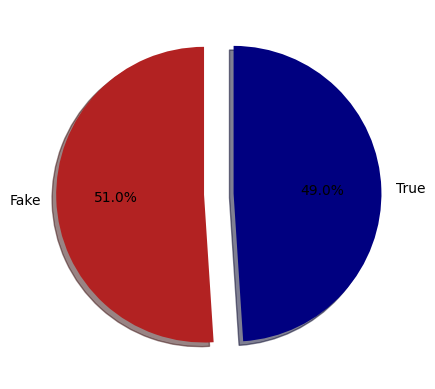

In [12]:
import matplotlib.pyplot as plt

# Checking if our df is well balanced
label_size = [df['label'].sum(),len(df['label'])-df['label'].sum()]
plt.pie(label_size,explode=[0.1,0.1],colors=['firebrick','navy'],startangle=90,shadow=True,labels=['Fake','True'],autopct='%1.1f%%')

## Creating a pytorch dataset

In [13]:
# Create a pytorch dataset to ensure consistency in our data handling

# Create a train and eval datasets using the specified columns from the DataFrame
train_dataset = Dataset.from_pandas(train[['Unnamed: 0', 'title', 'text', 'label']])
eval_dataset = Dataset.from_pandas(eval[['Unnamed: 0', 'title', 'text', 'label']])

# Combine the train and eval datasets into a DatasetDict
dataset = DatasetDict({'train': train_dataset, 'eval': eval_dataset})

# Remove the '__index_level_0__' column from the dataset
dataset = dataset.remove_columns('__index_level_0__')
dataset

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'title', 'text', 'label'],
        num_rows: 57229
    })
    eval: Dataset({
        features: ['Unnamed: 0', 'title', 'text', 'label'],
        num_rows: 14308
    })
})

## Preprocessing and tokenization

In [14]:
# define helper functions

# funtion to replace usernames and links with placeholders.
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

In [15]:
# Define the apply_preprocess function
def apply_preprocess(dataset, column='title'):
    return dataset.map(lambda example: {column: preprocess(example[column])},
                       remove_columns=[column])

# Apply the preprocess function to the 'title' column in both 'train' and 'eval' datasets
dataset['train'] = apply_preprocess(dataset['train'])
dataset['eval'] = apply_preprocess(dataset['eval'])

Map:   0%|          | 0/57229 [00:00<?, ? examples/s]

Map:   0%|          | 0/14308 [00:00<?, ? examples/s]

###Tokenization

Text(0, 0.5, 'Number of texts')

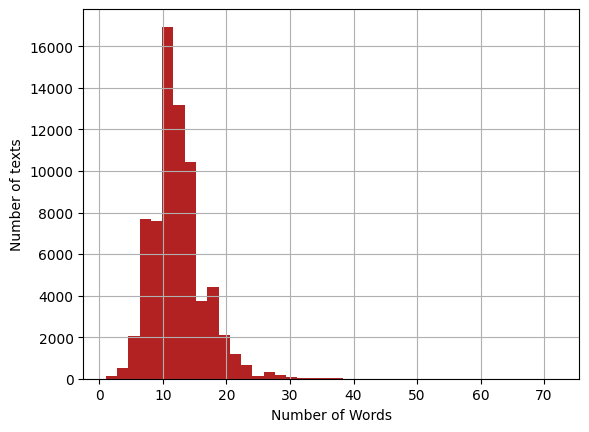

In [16]:
# Plot histogram of the number of words in train data 'text'
seq_len = [len(text.split()) for text in df['title']]

pd.Series(seq_len).hist(bins = 40,color='firebrick')
plt.xlabel('Number of Words')
plt.ylabel('Number of texts')

In [17]:
# "jy46604790/Fake-News-Bert-Detect"
# define the tokenizer
tokenizer = AutoTokenizer.from_pretrained("jy46604790/Fake-News-Bert-Detect")

def tokenize_data(example):
    return tokenizer(example['title'], padding='max_length',
                     truncation=True,
                     max_length=20
                     )

# Change the tweets to tokens that the models can exploit
dataset = dataset.map(tokenize_data, batched=True)

# Transform	labels and remove the useless columns
remove_columns = ['Unnamed: 0', 'title', 'text']
dataset = dataset.map(remove_columns=remove_columns)
dataset

Map:   0%|          | 0/57229 [00:00<?, ? examples/s]

Map:   0%|          | 0/14308 [00:00<?, ? examples/s]

Map:   0%|          | 0/57229 [00:00<?, ? examples/s]

Map:   0%|          | 0/14308 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 57229
    })
    eval: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 14308
    })
})

## Trianing

In [18]:
# Loading a pretrain model for fine-tuning
model = AutoModelForSequenceClassification.from_pretrained("jy46604790/Fake-News-Bert-Detect")

In [19]:
# Configure the trianing parameters like `num_train_epochs`:
# the number of time the model will repeat the training loop over the dataset
training_args = TrainingArguments("test_trainer",
                                  num_train_epochs=2,
                                  load_best_model_at_end=True,
                                  save_strategy='epoch',
                                  evaluation_strategy='epoch',
                                  logging_strategy='epoch',
                                  # logging_steps=100,
                                  per_device_train_batch_size=32,
                                  )

In [20]:
# set up the optimizer with the PyTorch implementation of AdamW
import torch
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

In [21]:
train_dataset = dataset['train'].shuffle(seed=24)
eval_dataset = dataset['eval'].shuffle(seed=24)

In [22]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        "rmse": mean_squared_error(labels, predictions, squared=False),
        "classification_report": classification_report(labels, predictions)
    }

In [23]:
trainer = Trainer(
    model,
    training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [24]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Rmse,Classification Report
1,0.199400,0.187466,0.255222,precision recall f1-score support 0 0.89 0.98 0.94 7006 1 0.98 0.89 0.93 7302 accuracy 0.93 14308 macro avg 0.94 0.94 0.93 14308 weighted avg 0.94 0.93 0.93 14308
2,0.112800,0.131192,0.210335,precision recall f1-score support 0 0.94 0.97 0.96 7006 1 0.97 0.94 0.96 7302 accuracy 0.96 14308 macro avg 0.96 0.96 0.96 14308 weighted avg 0.96 0.96 0.96 14308


Trainer is attempting to log a value of "              precision    recall  f1-score   support

           0       0.89      0.98      0.94      7006
           1       0.98      0.89      0.93      7302

    accuracy                           0.93     14308
   macro avg       0.94      0.94      0.93     14308
weighted avg       0.94      0.93      0.93     14308
" of type <class 'str'> for key "eval/classification_report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "              precision    recall  f1-score   support

           0       0.94      0.97      0.96      7006
           1       0.97      0.94      0.96      7302

    accuracy                           0.96     14308
   macro avg       0.96      0.96      0.96     14308
weighted avg       0.96      0.96      0.96     14308
" of type <class 'str'> for key "eval/classification_report" as a scalar. This invocation of Ten

TrainOutput(global_step=3578, training_loss=0.15608896817356066, metrics={'train_runtime': 589.7833, 'train_samples_per_second': 194.068, 'train_steps_per_second': 6.067, 'total_flos': 1176373639624800.0, 'train_loss': 0.15608896817356066, 'epoch': 2.0})

Don't worry the above issue, it is a `KeyboardInterrupt` that means I stopped the training to avoid taking a long time to finish.

In [25]:
# Launch the final evaluation
trainer.evaluate()

Trainer is attempting to log a value of "              precision    recall  f1-score   support

           0       0.94      0.97      0.96      7006
           1       0.97      0.94      0.96      7302

    accuracy                           0.96     14308
   macro avg       0.96      0.96      0.96     14308
weighted avg       0.96      0.96      0.96     14308
" of type <class 'str'> for key "eval/classification_report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.1311921626329422,
 'eval_rmse': 0.21033540849048413,
 'eval_classification_report': '              precision    recall  f1-score   support\n\n           0       0.94      0.97      0.96      7006\n           1       0.97      0.94      0.96      7302\n\n    accuracy                           0.96     14308\n   macro avg       0.96      0.96      0.96     14308\nweighted avg       0.96      0.96      0.96     14308\n',
 'eval_runtime': 35.788,
 'eval_samples_per_second': 399.799,
 'eval_steps_per_second': 49.989,
 'epoch': 2.0}

## Pushing to HuggingFace
Some checkpoints of the model are automatically saved locally in `test_trainer/` during the training.

You may also upload the model on the Hugging Face Platform... [Read more](https://huggingface.co/docs/hub/models-uploading)

In [26]:
huggingface_hub.notebook_login()
# login to the Hugging Face Hub with your token

In [28]:
# # Push model and tokenizer to HugginFace
model.push_to_hub("ikoghoemmanuell/finetuned_fake_news_bert")
tokenizer.push_to_hub("ikoghoemmanuell/finetuned_fake_news_bert")

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/ikoghoemmanuell/finetuned_fake_news_bert/commit/c975bef5b3edc650ba9c8bb9b88c1b8f27a04951', commit_message='Upload tokenizer', commit_description='', oid='c975bef5b3edc650ba9c8bb9b88c1b8f27a04951', pr_url=None, pr_revision=None, pr_num=None)